In [1]:
import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

## Step 1. 데이터 수집하기

In [2]:
data = pd.read_csv("~/data/ChatbotData .csv")
data = data[["Q", "A"]]
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [3]:
print("총 데이터 수 :", len(data))

총 데이터 수 : 11823


In [4]:
## 결측치 확인
data.isna().sum()

Q    0
A    0
dtype: int64

In [5]:
## 중복값 확인
data[data.duplicated()]

,Q,A
5527,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.
5537,고백하고 후회하면 어떡하지,후회는 후회를 낳을뿐이에요. 용기 내세요.
5542,공부는 내 체질이 아닌 것 같아,확신이 없나봐요.
5704,기숙사 괜찮을까,혼자 사는 것보다 불편하겠죠.
5774,나는 좋은데 ….,현실의 벽에 부딪혔나봐요.
...,...,...
8764,환승 가능?,환승은 30분 안에
8780,회사 사람들이 아직도 불편해,회사에는 동료가 있을 뿐이에요.
8782,회사에는 왜 친구 같은 사람이 없을까,회사는 친구 사귀는 곳이 아니에요.
8789,후련하달까,후련하니 다행이에요.


## Step 2. 데이터 전처리하기

In [6]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence의 영어는 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower()
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, 0-9, ".", "?", "!", ",", 가-힣)를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^a-zA-Z0-9.,?!가-힣]', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [7]:
questions = data["Q"].apply(preprocess_sentence).tolist()
answers = data["A"].apply(preprocess_sentence).tolist()

In [8]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## Step 3. SubwordTextEncoder 사용하기

#### 1. 단어장(Vocabulary) 만들기

In [9]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [11]:
print('vocab size :', [tokenizer.vocab_size])
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

vocab size : [8164]
START_TOKEN의 번호 : [8164]
END_TOKEN의 번호 : [8165]


In [12]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8166


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [13]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5758, 610, 2487, 4159]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7504, 7, 6268, 97, 1]


In [14]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 12 ## 15 <- 40
print(MAX_LENGTH)

12


In [15]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40->15으로 모든 데이터셋을 패딩 -> postd와 pre 중 실험 해볼 것
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
    )

    return tokenized_inputs, tokenized_outputs

In [16]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8166
필터링 후의 질문 샘플 개수: 10744
필터링 후의 답변 샘플 개수: 10744


#### 3. 교사 강요(Teacher Forcing) 사용하기

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

## 데이터가 디스크에서 한 번만 로드되도록 하여 성능을 향상
dataset = dataset.cache()

## BUFFER_SIZE만큼 데이터를 섞음
dataset = dataset.shuffle(BUFFER_SIZE)

## BATCH_SIZE만큼의 샘플로 묶음
dataset = dataset.batch(BATCH_SIZE)

## 모델이 학습을 하는 동안 다음 배치를 미리 준비
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기

#### Positional Encoding Layer

In [18]:
## 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    ## 각도 배열 생성    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )

        ## 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        
        ## 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        ## sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#### Scaled Dot Product Attention

In [19]:
## 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    ## 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    ## 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    ## 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    ## softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    ## 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    
    return output

#### MultiHeadAttention 구현

In [20]:
## MultiHeadAttention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads ## multi heads 수
        self.d_model = d_model ## embedding layer 수

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)  
        key = self.key_dense(key)        
        value = self.value_dense(value)  

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)      
        value = self.split_heads(value, batch_size) 

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

#### Masking

In [21]:
## Padding Masking
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
## Look-ahead masking
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    
    return tf.maximum(look_ahead_mask, padding_mask)

#### Encoder

In [23]:
## 인코더 하나의 레이어를 함수로 구현.
## 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    ## 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    ## 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
        })

    ## 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6
        )(inputs + attention) ## 잔차 연결

    ## 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    ## 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs) 

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [24]:
## Encoder
def encoder(
    vocab_size,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name="encoder"
    ):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    ## 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    ## 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    ## 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    ## num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
            )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### Decoder

In [25]:
## 디코더 하나의 레이어를 함수로 구현.
## 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    ## Look ahead mask 사용
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    
    ## 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    ## 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    ## 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs) ## 잔차연결

    ## 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    ## 마스크드 멀티 헤드 어텐션의 결과는
    ## Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    ## 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    ## 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [26]:
## Decoder
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    ## look ahead mask 사용
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    ## 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    ## 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    ## 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    ## Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [27]:
def transformer(
    vocab_size,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name="transformer"
   ):
    ## encoder input & decoder input
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    ## 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask'
        )(inputs)

    ## 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    ## 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask'
        )(dec_inputs)

    ## 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    ## 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    ## 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    ## 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    ## 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 모델 생성

In [28]:
tf.keras.backend.clear_session()

## 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 2048 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.15 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    23095296    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 손실 함수 

In [29]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask) ## padding 부분은 빼고 loss를 계산한다?

    return tf.reduce_mean(loss)

#### 커스텀 된 학습률(Learning rate)

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### 모델 컴파일

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### Early Stopping

In [107]:
# es = EarlyStopping(
#     monitor='val_loss', 
#     patience=5, 
#     restore_best_weights=True
# )

#### 훈련하기

In [32]:
history = model.fit(
    dataset, 
    epochs=30, 
    verbose=1, 
#     callbacks=[es]  ## 에러: validation set이 없어서 작동이 안된다. 
)

Epoch 1/30
168/168 [==============================] - 38s 113ms/step - loss: 4.4314 - accuracy: 0.0848
Epoch 2/30
168/168 [==============================] - 19s 113ms/step - loss: 3.5230 - accuracy: 0.1752
Epoch 3/30
168/168 [==============================] - 19s 114ms/step - loss: 3.1994 - accuracy: 0.1784
Epoch 4/30
168/168 [==============================] - 19s 115ms/step - loss: 3.0551 - accuracy: 0.1839
Epoch 5/30
168/168 [==============================] - 19s 116ms/step - loss: 2.9595 - accuracy: 0.1897
Epoch 6/30
168/168 [==============================] - 20s 116ms/step - loss: 2.8641 - accuracy: 0.1950
Epoch 7/30
168/168 [==============================] - 20s 117ms/step - loss: 2.7664 - accuracy: 0.1996
Epoch 8/30
168/168 [==============================] - 20s 117ms/step - loss: 2.6753 - accuracy: 0.2038
Epoch 9/30
168/168 [==============================] - 19s 116ms/step - loss: 2.5865 - accuracy: 0.2083
Epoch 10/30
168/168 [==============================] - 19s 116ms/step - l

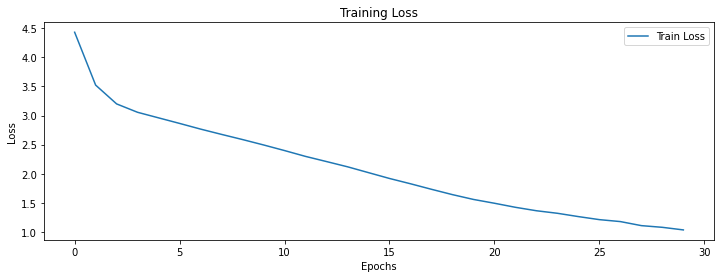

In [33]:
## loss 시각화
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Step 5. 모델 평가하기

In [34]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    ## 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    ## ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    ## 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    ## 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    ## 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        ## 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        ## 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        ## 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        ## 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        ## 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [35]:
def sentence_generation(sentence):
    ## 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    ## 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [36]:
## 영어는 답변을 못한다. 
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : 먼저 연락을 해보세요 .


'먼저 연락을 해보세요 .'

In [37]:
sentence_generation('컴퓨터가 망가졌어')

입력 : 컴퓨터가 망가졌어
출력 : 잘 찾아보세요 .


'잘 찾아보세요 .'

In [38]:
sentence_generation('머리가 복잡해')

입력 : 머리가 복잡해
출력 : 제가 들어드릴게요 .


'제가 들어드릴게요 .'

In [39]:
sentence_generation('배가 아파')

입력 : 배가 아파
출력 : 저랑 놀아요 .


'저랑 놀아요 .'

In [40]:
sentence_generation('물건이 망가졌어')

입력 : 물건이 망가졌어
출력 : 사랑은 한 순간로로로로까지 없을 거예요 .


'사랑은 한 순간로로로로까지 없을 거예요 .'

In [41]:
sentence_generation('나랑 놀아줘')

입력 : 나랑 놀아줘
출력 : 잘 찾아보세요 .


'잘 찾아보세요 .'

In [42]:
sentence_generation('컴퓨터가 망가졌어')

입력 : 컴퓨터가 망가졌어
출력 : 잘 찾아보세요 .


'잘 찾아보세요 .'

max_length를 40으로 했을 때 질문에 대한 답변이 이상하다. 
```
입력 : Where have you been?
출력 : 시간 

입력 : 컴퓨터가 망가졌어
출력 : 맛있게 
```
**다시 해야겠다.^^**  

max_length를 12로 했을 때 질문이 그렇게 잘 나온 것 같진 않다. 

## 회고
점점 무거운 모델을 사용하면서 학습하는데 시간이 많이 걸리기 시작했다.  
앞에서 잘못 돌리면 수정하고 다시 돌리는데 시간이 너무 많이 걸렸다. 
꼼꼼히 확인하고 돌려야겠다. 